<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Pipeline de Dados do Telegram II
Caderno de **Exercícios**<br> 
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

---

# **Execução**

## 1\. Ingestão

1.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados crus, não se esqueça de adicionar o sufixo `-raw`.

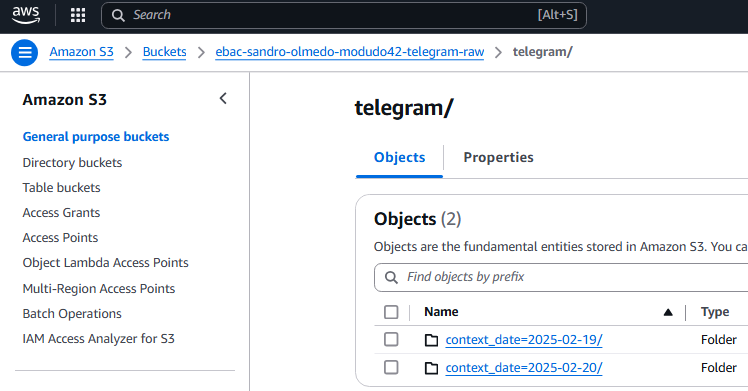

1.2. Crie uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Não se esqueça de configurar as variáveis de ambiente e de adicionar as permissão de interação com `AWS S3` no `AWS IAM`.

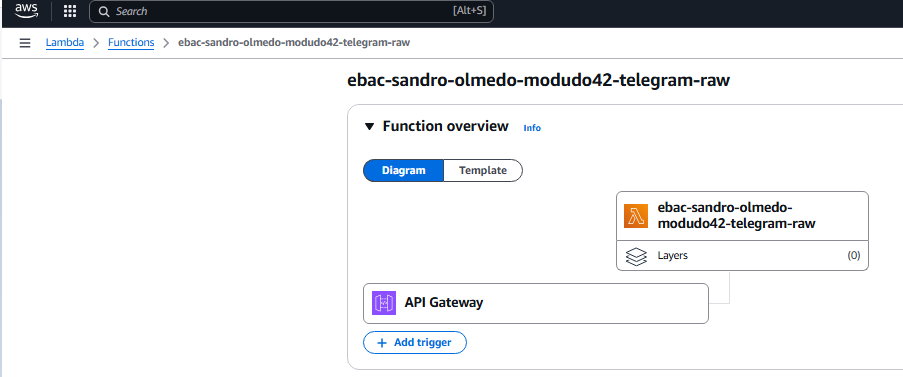 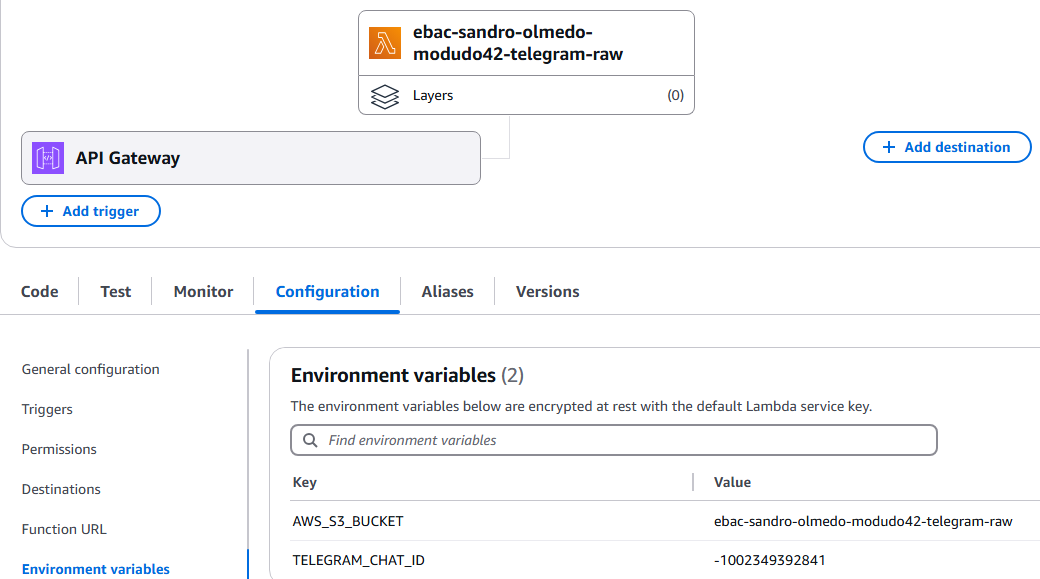 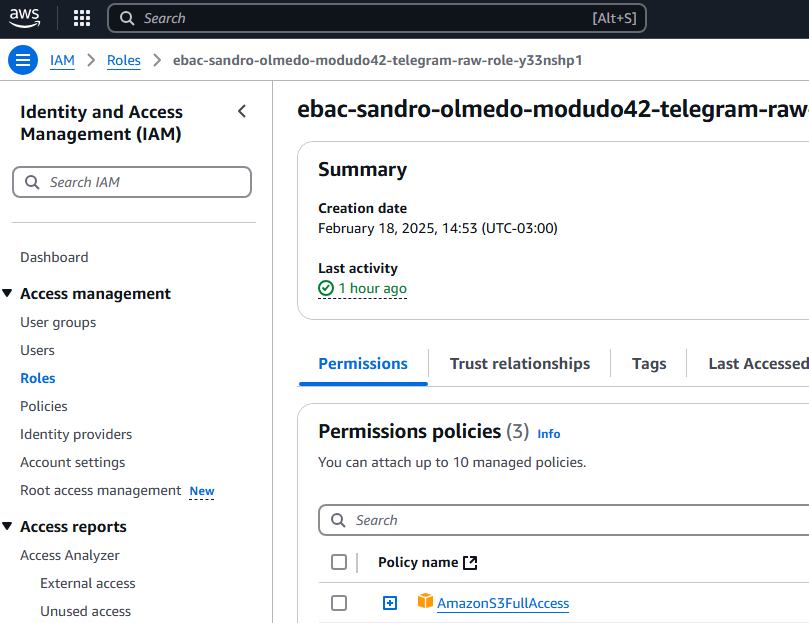

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. Lembre-se que o primeiro só faz sentido na integração com o `AWS API Gateway`.

> **Nota**: Neste exemplo as permissões de acesso da função lambda ao Bucket S3 de dados crus esta com acesso total, isso não é recomendável em projetos reais nas empresas, configure-os de acordo com as políticas da empresa.

## Código da função Lambda para recebimento das mensagens da API e armazenamento no formato JSON no Bucket S3 (cru)

### > **Nota:** Esta parte desde projeto foi realizado todo em Python no AWS Lambda

In [ ]:

import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:
  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente
  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas para tratar dados temporais
  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal
  client = boto3.client('s3')
  
  try:

    #message = json.loads(event["body"])
    message = event
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")
     

1.3. Crie uma API no `AWS API Gateway` e conecte a função do `AWS Lambda`, conforme apresentado na aula.

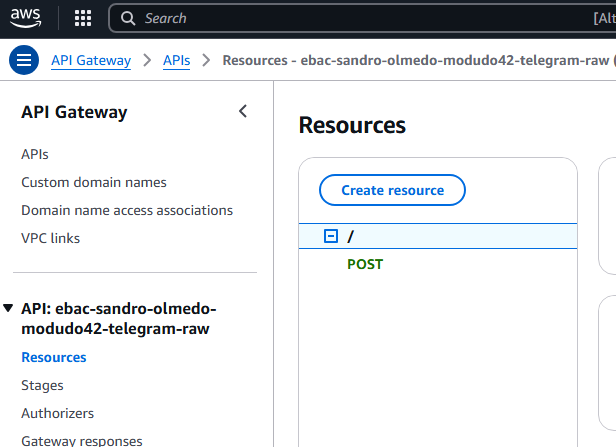


> **Nota**: não disponibilize o endereço da API gerada.

1.4. Configura o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. utilize o endereço da API criada no `AWS API Gateway`. Utilize o método `getWebhookInfo` para consultar a integração.

## Código Python para consumo dos dados gerados no Chatbot do telegram via API

### > **Nota:** Esta parte desde projeto foi realizado todo em Python no VSCODE, pode ser que em alguma parte do código seja necessário ajusta-lo dependendo da IDE...

In [ ]:
import json

import requests


from getpass import getpass

token = getpass()


base_url = f'https://api.telegram.org/bot{token}' # token gerado na criação do bot telegram

aws_api_gateway_url = getpass() # url gerada ao criar a api gateway no aws para comunicação com o telegram

response = (requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')) # Ativação do Webhook telegram com a url da api gateway, se for True, então tudo ocorreu da forma correta
print(json.dumps(json.loads(response.text), indent=2))


response = requests.get(url=f'{base_url}/getWebhookInfo') # Verificação do status da integração Webhook, se for True, então tudo ocorreu da forma correta

print(json.dumps(json.loads(response.text), indent=2))

**Response:**

In [ ]:
{
  "ok": true,
  "result": true,
  "description": "Webhook is already set"
}
{
  "ok": true,
  "result": {
    "url": "https://###############################################",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "15.229.97.62"
  }
}

> **Nota**: não disponibilize o *token* de acesso ao seu *bot* da API de *bots* do **Telegram**.

## 2\. ETL

Replique as atividades da aula 2.

2.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, não se esqueça de adicionar o sufixo `-enriched`.

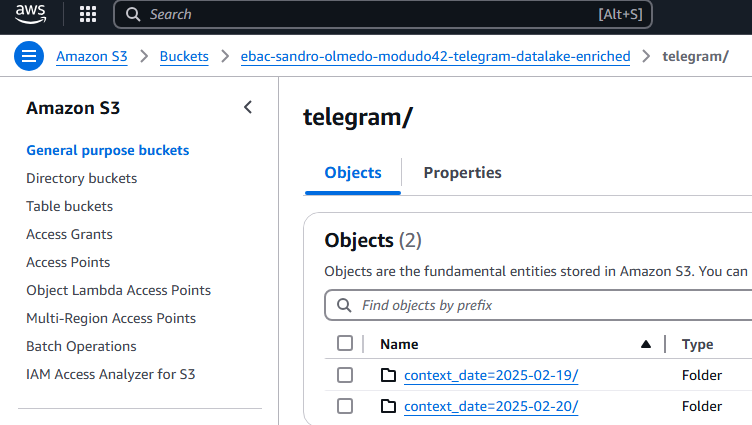

2.2. Cria uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salve o resultado em um único arquivo PARQUET, também particionado por dia. Não se esqueça de configurar as variáveis de ambiente, de adicionar as permissão de interação com `AWS S3` no `AWS IAM`, de configurar o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

> **Nota**: Para testar a função, substitua o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

> **Nota**: Neste exemplo as permissões de acesso da função lambda ao Bucket S3 de dados crus e ao Bucket S3 de dados enriquecidos esta com acesso total, isso não é recomendável em projetos reais nas empresas, configure-os de acordo com as políticas da empresa.

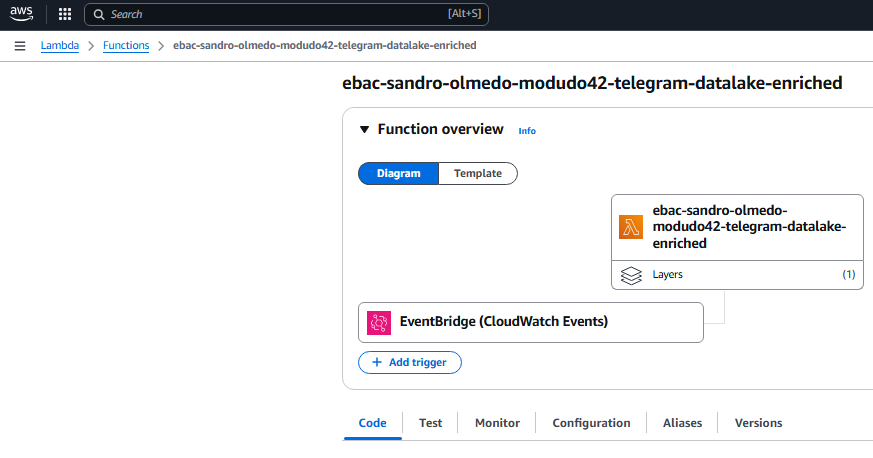 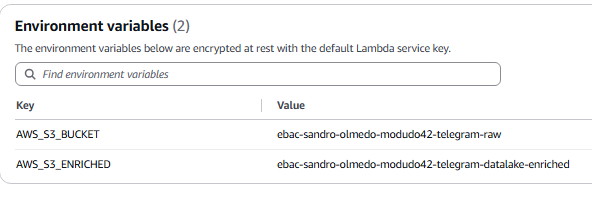 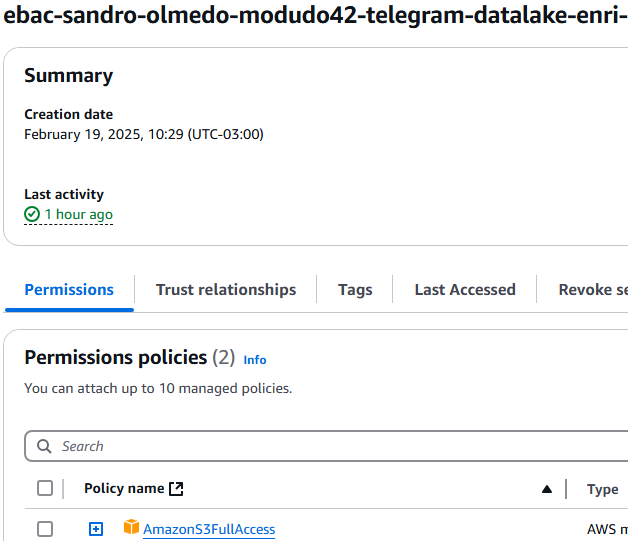

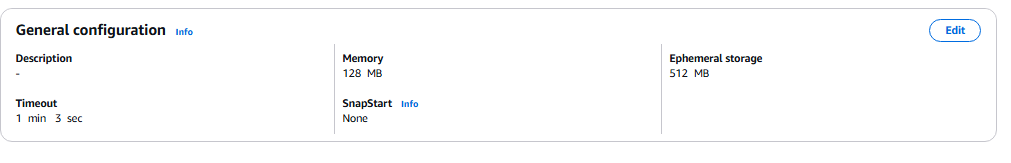 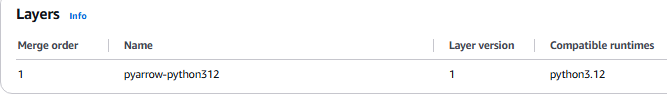

## Código da função lambda para captura e tratamento dos dados do Bucket S3 cru e posterior armazenamento no Bucket S3 enriquecido no formato `parquet`

### > **Nota:** Esta parte desde projeto foi realizado todo em Python no AWS Lambda

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq

def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')
  #date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        # Download dos dados crus do bucket de dados crus para posterior transformação e upload no bucket de dados enriquecidos

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      # Upload dos dados enriquecidos para o bucket de dados enriquecidos, particionados por data de ingestão de dados na API Gateway da AWS, compactados e orientados por colunas com a utilização do formato PARQUET

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False
  

  # Função auxiliar para parsear os dados crus e armezana-los em um dicionário e enviar para o bucket de dados enriquecidos

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

    if key == 'from':
      for k, v in data[key].items():
        if k in ['id','is_bot','first_name']:
          parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
      for k, v in data[key].items():
        if k in ['id','type']:
          parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
      parsed_data[key] = [value]

  if not 'text'in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

2.3. Crie uma regra no `AWS Event Bridge` para executar automaticamente a função do `AWS Lambda` criada anteriormente que enriquece os dados, Configure a regra para que seja executada todos os dias a meia noite no horário de Brasília (GMT-3).

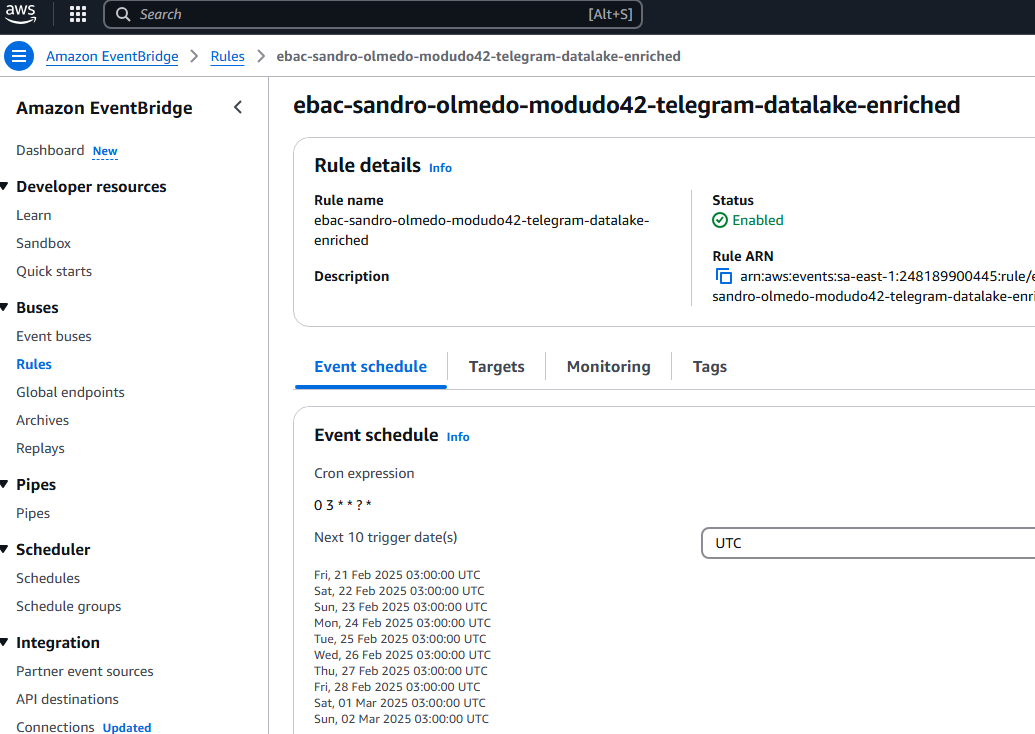

## 3\. Apresentação

Replique as atividades da aula 3.

3.1. Cria a tabela no `AWS Athena` que aponte para os dados armazenados no `Bucket S3 Enriquecido`

In [ ]:
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint, 
  `user_id` bigint, 
  `user_is_bot` boolean, 
  `user_first_name` string, 
  `chat_id` bigint, 
  `chat_type` string, 
  `text` string, 
  `date` bigint)
PARTITIONED BY ( 
  `context_date` date)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://ebac-sandro-olmedo-modudo42-telegram-datalake-enriched/telegram'

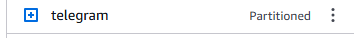

3.2. Execute o comando `MSCK REPAIR TABLE <nome-tabela-criada>` para carregar as partições.

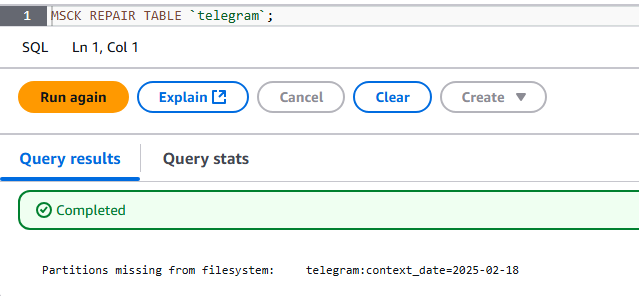

3.3. Execute algumas consultas SQL para explorar os dados.

#### Consulta no AWS Athena para verificar quantas linhas de mensagens o usuário ou cliente enviou por dia e agrupadas por usuário, como é um projeto de teste, só tem um usuário neste exemplo!

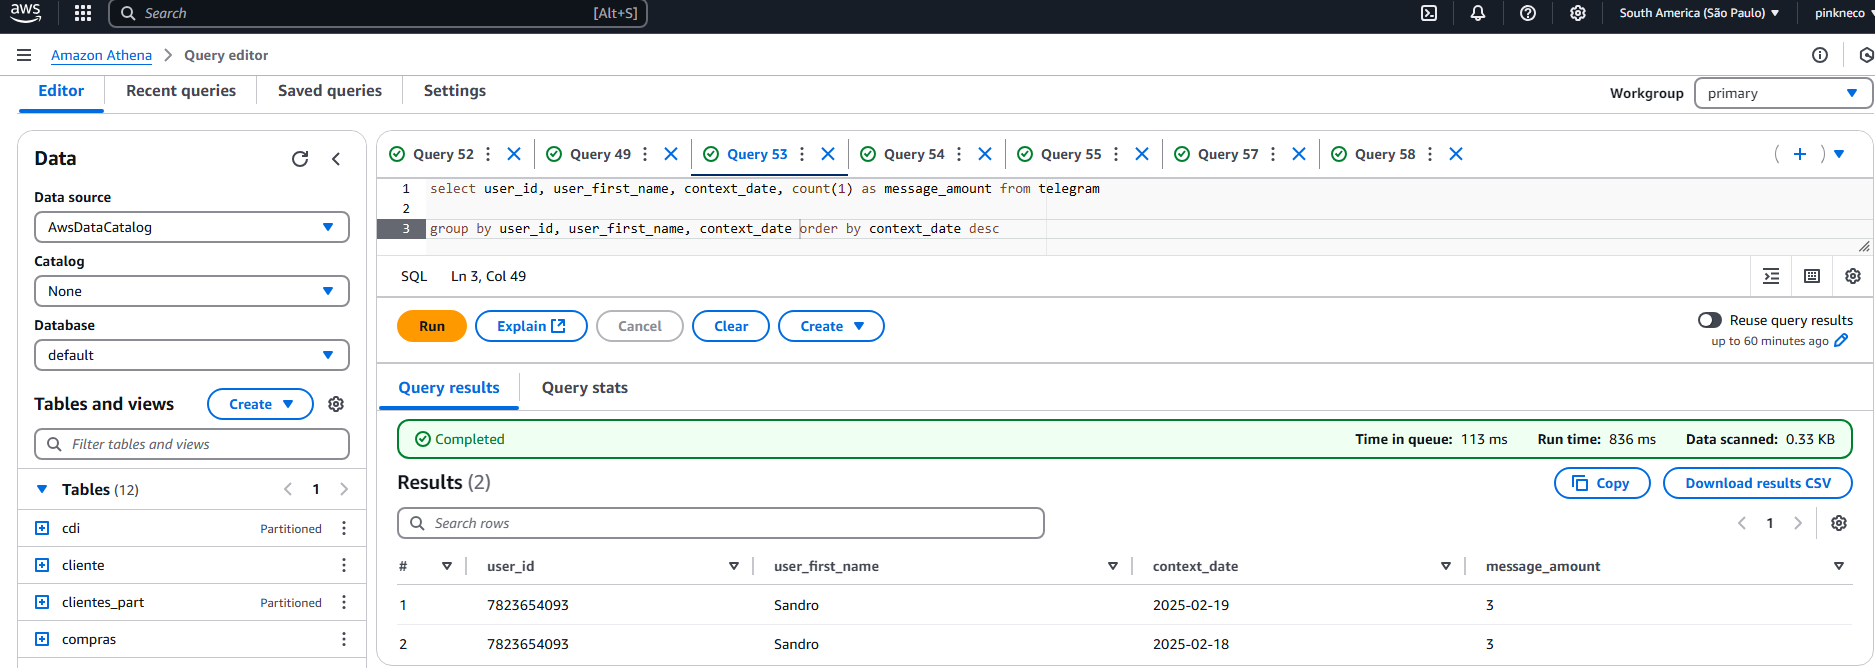
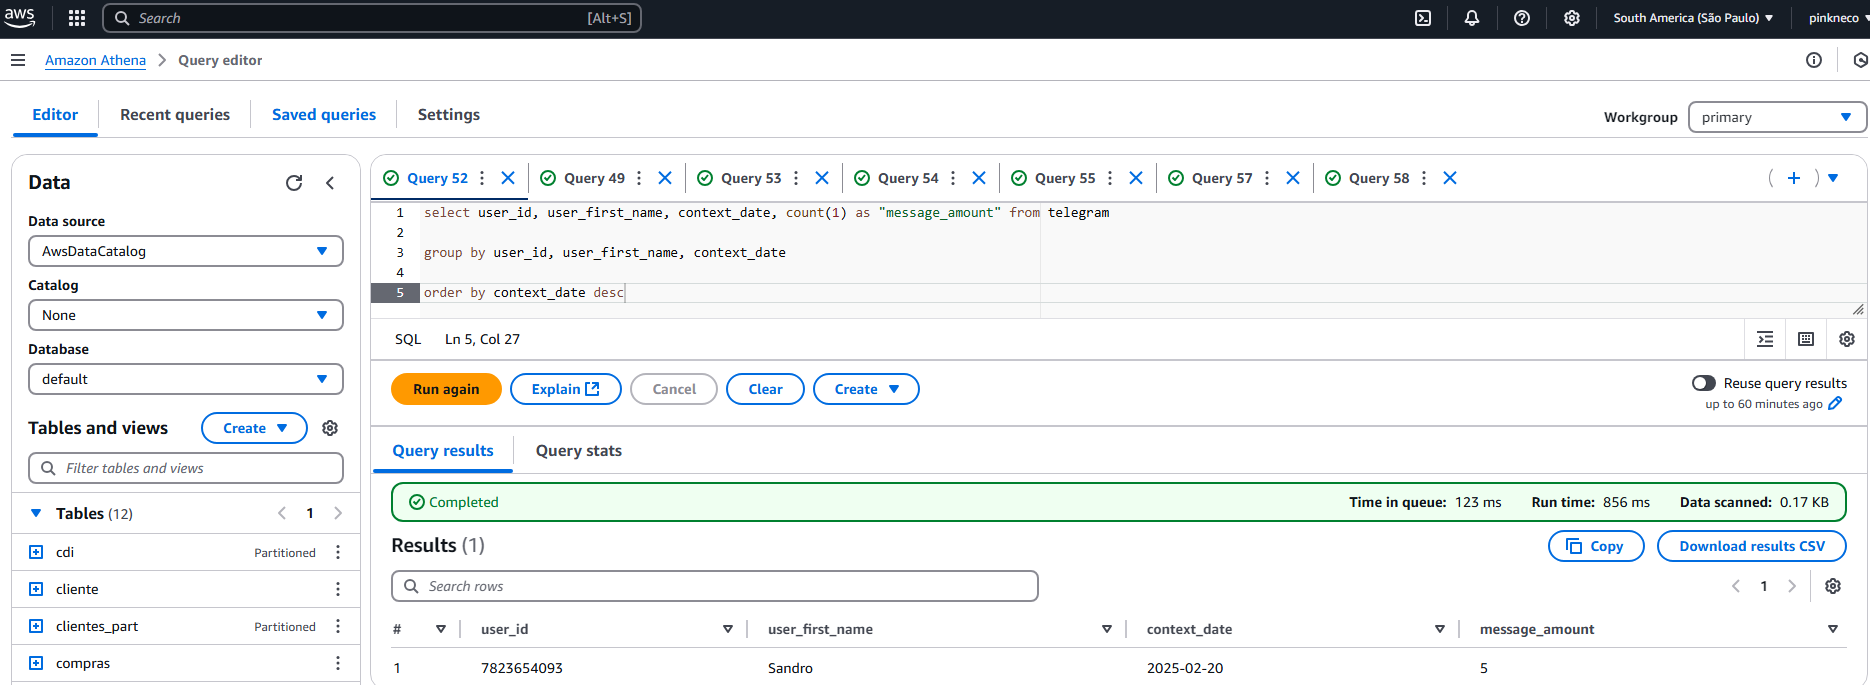

#### Consulta no AWS Athena para verificar quantas linhas de mensagens foram enviadas por dia de todos os usuários.

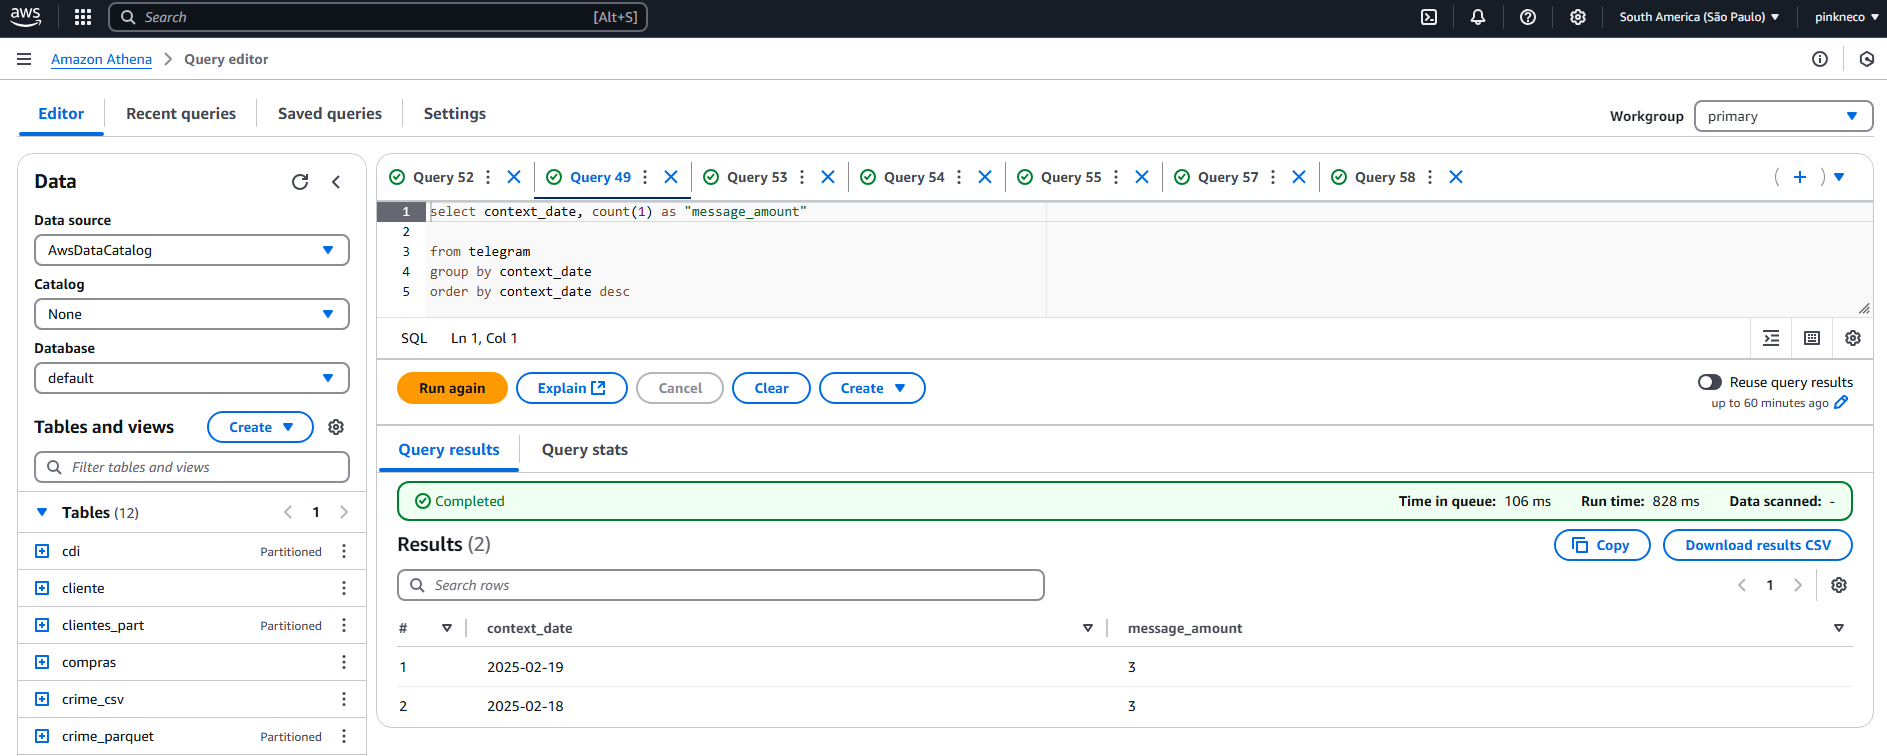

#### Consulta completa no AWS Athena, aqui é possível ter uma visão geral de todas as colunas da tabela e verificar na coluna `text` o conteúdo de cada linha de mensagens, a partir daí podem ser realizadas inúmeras analises dos textos, exemplo: qual a palavra que mais aparece, as possibilidades são quase que infinitas para geração de insigths, basta ser analítico e criativo de acordo com as necessidades...

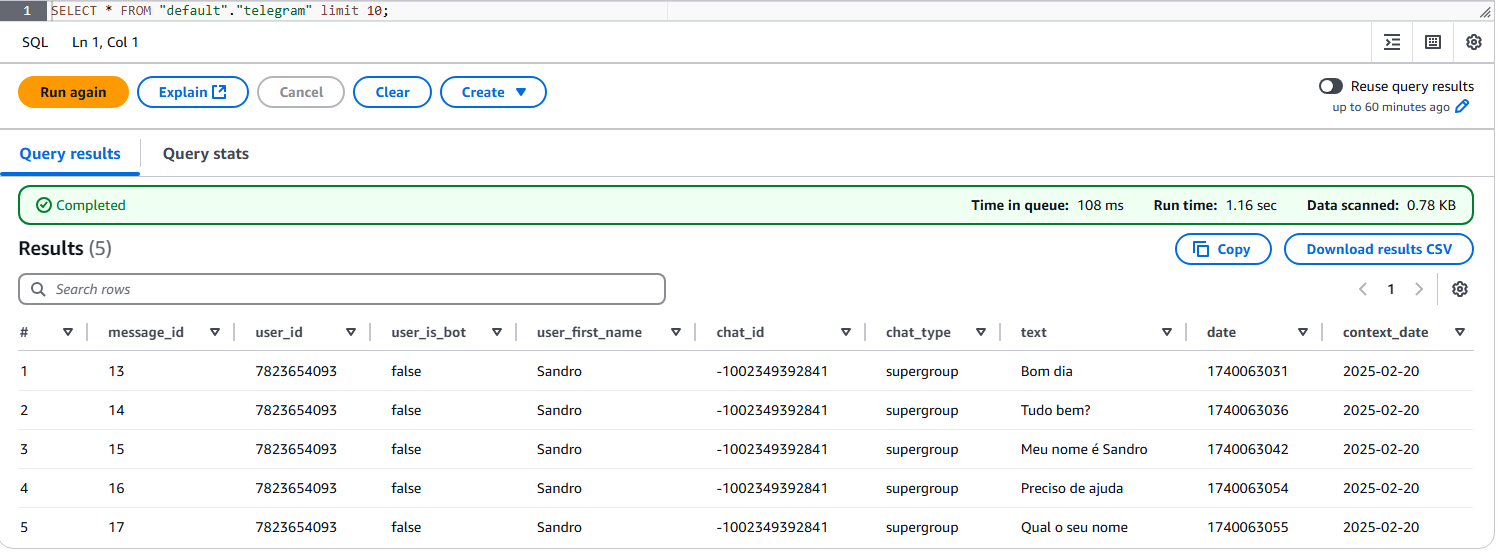

#### Consulta no AWS Athena para verificar as mensagens enviadas agrupadas por hora, dia da semana, número da semana e quantidade de mensagens enviadas em cada hora.

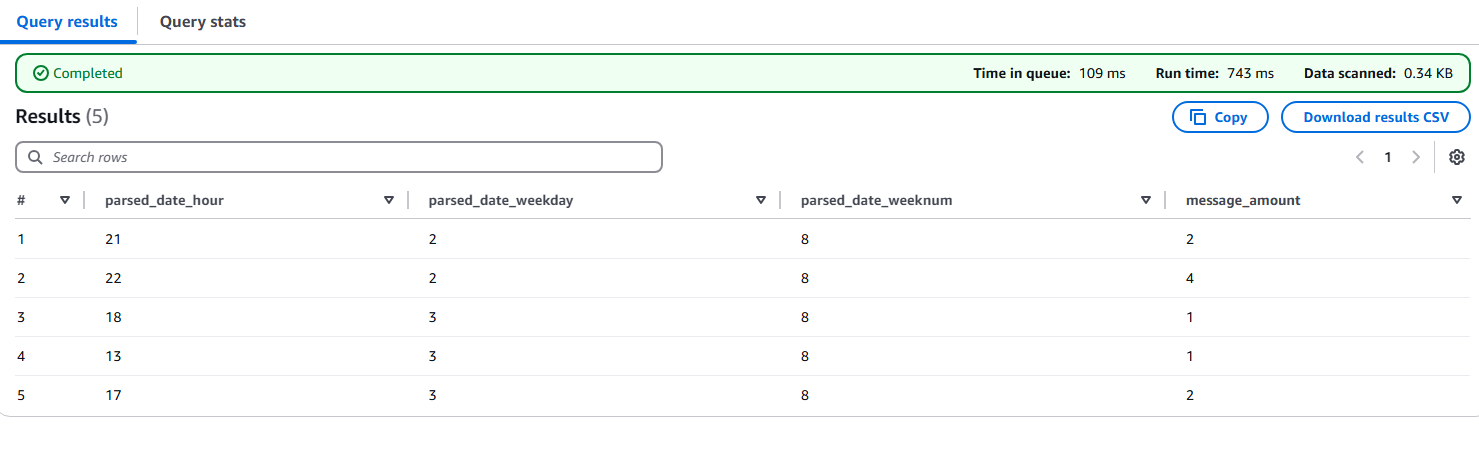

# Aqui uma breve abordagem de uma das possibilidades de analises de dados com relação à quantidade de mensagens enviadas por hora em um chatbot do telegram.
#### A base de dados utilizada foi um arquivo CSV gerado a partir de uma consulta SQL realizada no AWS Athena em um Buncker que contem dados enriquecidos oriundos do chatbot do telegram. Após isso, foi feito o Download do CSV para a máquina local para consumo via `pandas` e `seaborn`.
#### Foi gerado DataFrame Pandas e um gráfico de barras simples para verificar em qual horário foram enviadas mais mensagens e então analisar o porque de determinado horário possuir mais mensagens e assim tomar decisões que gerem valor para os interessados...



In [7]:
import seaborn as sns

import pandas as pd

import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('message_hour.csv')

df = pd.DataFrame(df)

df.head()

,parsed_date_hour,parsed_date_weekday,parsed_date_weeknum,message_amount
0,21,2,8,2
1,22,2,8,4
2,18,3,8,1
3,13,3,8,1
4,17,3,8,2


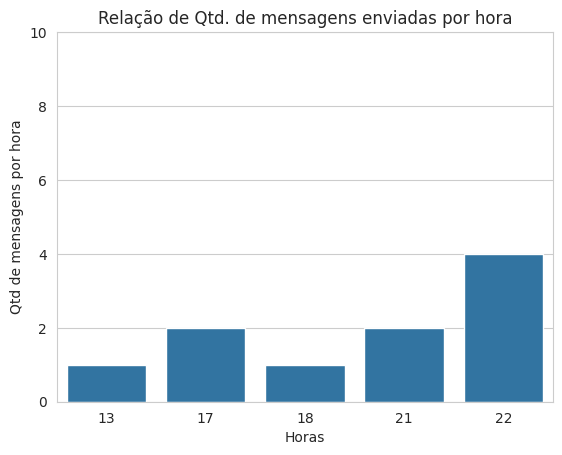

In [9]:
x = df[['parsed_date_hour','message_amount']]

with sns.axes_style('whitegrid'):

    grafico = sns.barplot(data=x, x='parsed_date_hour', y='message_amount')

    plt.ylim(0, 10) # definir limite do eixo

    grafico.set(title='Relação de Qtd. de mensagens enviadas por hora', xlabel='Horas', ylabel='Qtd de mensagens por hora');


## 4\. Storytelling

Siga as dicas da aula 4 para expor o seu projeto.

**Ferramentas utilizadas**

![Telegram](https://img.shields.io/badge/-Telegram_Bots-blue?style=flat-square&logo=telegram) 
![Amazon AWS](https://img.shields.io/badge/AWS-black?style=flat-square&logo=amazon-aws)
![Python](https://img.shields.io/badge/Python-black?style=flat-square&logo=python)
![SQL](https://img.shields.io/badge/-SQL-black?style=flat-square&logo=sqlite)

# 1. Abaixo o mapa do projeto de captação dos dados gerados (no Chatbot do Telegram) através de uma API

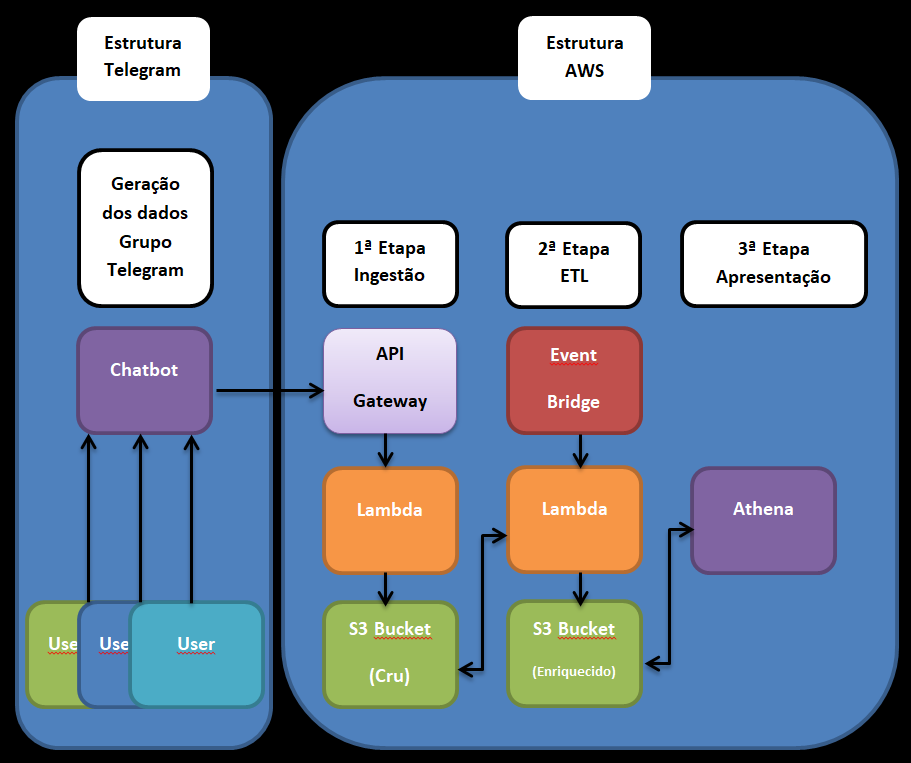
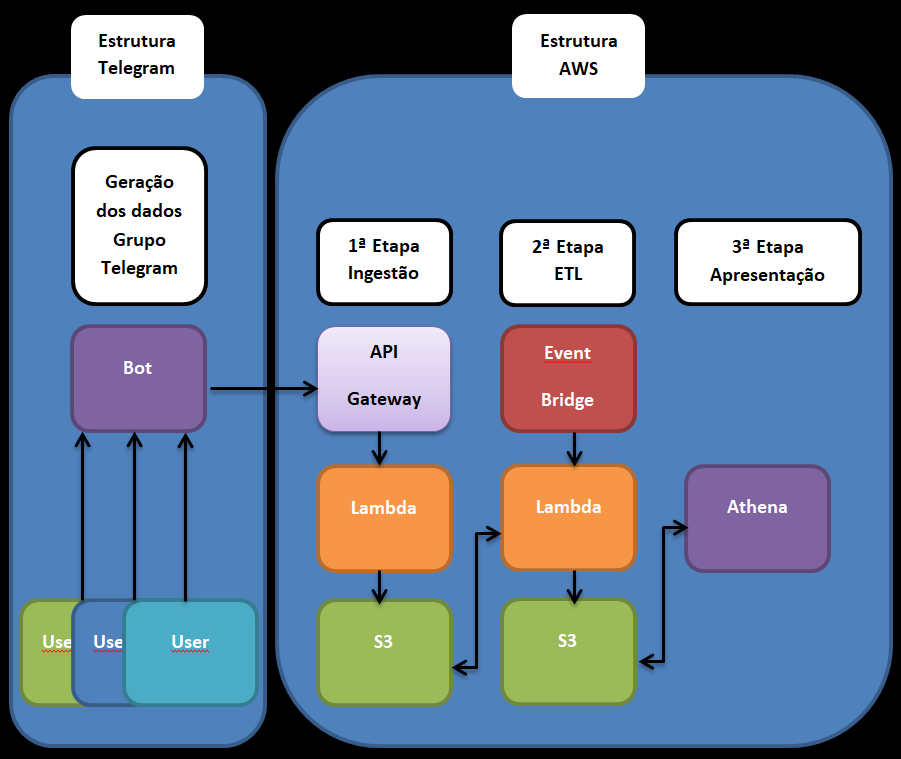
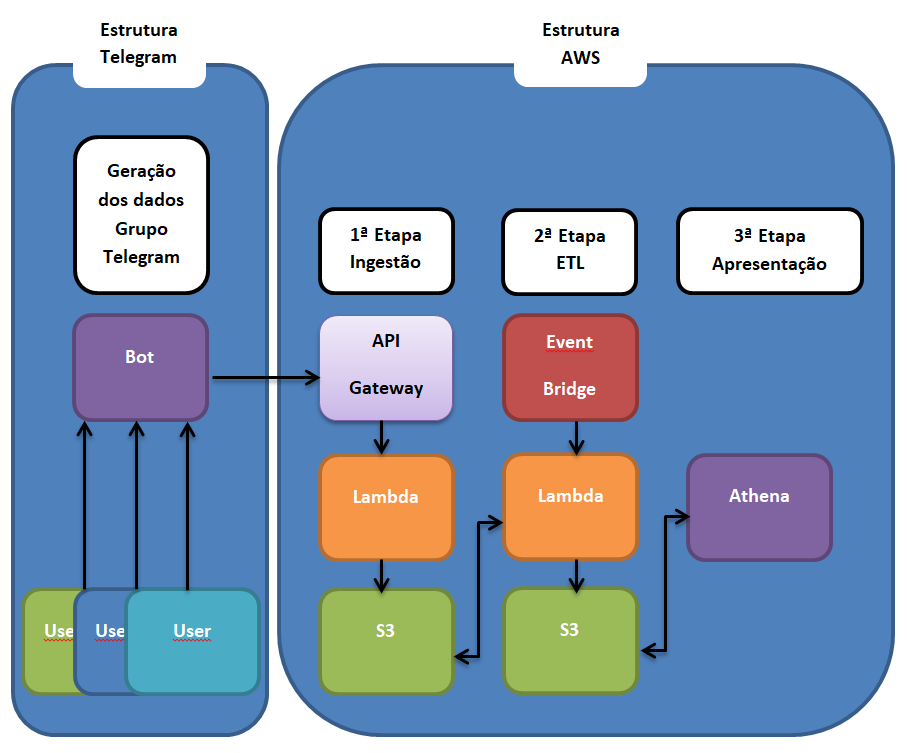

### No chatbot é onde estão os dados transacionais gerados no grupo do Telegram para atendimento aos usuários e clientes de uma empresas fictícia;
### Na 1ª etapa de ingestão os dados crus saem do Bot e passam pela AWS API Gateway através de uma url;
### Posteriormente uma função da AWS Lambda processa esses dados crus no formato JSON e armazena-os nesse mesmo formato em um AWS Bucket S3(cru);
### Já na 2ª etapa ETL outra função Lambda capta os dados crus transforma-os em dados enriquecidos e armazena-os em outro Bucket S3(enriquecido)  `parquet`, 
### no entanto, antes disso todos os dias é acionado um Event Bridge que verifica se existem novos dados crus no Bucket S3(cru) , se houver refaz toda a etapa de ETL novamente e armazena os novos dados no Bucket S3(enriquecido);
### Na 3ª etapa AWS Athena(etapa de consulta e geração de insights) são gerados consultas SQL em tabelas que possuem os dados que foram tratados do Bucket S3(enriquecido).
### Tudo isso permite a automatização de um sistema que possibilita a geração de valor e controle de qualidade de atendimento a usuários e clientes de várias empresas mundo afora!
### Imagine grandes empresas onde megabytes, gigabytes ou até mesmo terabytes de dados são gerados diariamente em sistemas de atendimento, sendo assim, somente um projeto como esse poderia lidar com tantos dados e ser capas de gerar valor e insights relevantes para a tomada de decisões importantes que alavanquem ainda mais os negócios empresariais e de outros setores!
### Além do mais é importante destacar que a AWS é uma das empresas possui os serviços mais baratos e robustos no que tange ao armazenamento e consumo de dados!
